# Data Augmentation Pipeline

### Imports

In [47]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image as image
import skimage.io
from joblib import Parallel, delayed
from skimage import transform, morphology, color
import cv2
import tensorflow as tf

### Konstanten

In [48]:
DATA_PATH = "../../../Pokemon-data/"
SUPPORTED_TYPES_LIST = [".png",".jpg","jpeg"]

## Augmentation Funktionen

### Color Augmentation

In [49]:
def increase_red_color(img, increase):
    """Increase red component of an image
        img: input image
        increase: summand for the r channel values
    """
    for i in img:
        for j in i:
            if not (j[0] >= (255-increase)):
                j[0] += increase
            if not (j[1] <= increase):
                j[1] -= increase
            if not (j[2] <= increase):
                j[2] -= increase
    return img

# Increase green component of an image
def increase_green_color(img, increase):
    # Green is to agressive
    for i in img:
        for j in i:
            if not (j[1] >= (255-increase)):
                j[1] += increase
            if not (j[0] <= increase):
                j[0] -= increase
            if not (j[2] <= increase):
                j[2] -= increase
    return img

# Increase blue component of an image
def increase_blue_color(img, increase):
    for i in img:
        for j in i:
            if not (j[2] >= (255-increase)):
                j[2] += increase
            if not (j[1] <= increase):
                j[1] -= increase
            if not (j[0] <= increase):
                j[0] -= increase
    return img

# Increase random color component of an image
def img_increase_random_color(img):
    np.random.seed()
    increase = np.random.randint(25, 55)
    np.random.seed()
    color = np.random.randint(0, 3)

    if color == 0:
        return increase_red_color(img, increase)
    if color == 1:
        return increase_green_color(img, increase)
    if color == 2:
        return increase_blue_color(img, increase)

# Grayscale Dilation
# Shouldn't be combined with random color increase
# Dilation enlarges bright regions and shrinks dark regions.
def img_dilation(img):
    return morphology.dilation(img)

def img_dilation_or_color(img):
    np.random.seed()
    selection = np.random.randint(0, 5)
    if selection == 0:
        return img_dilation(img)
    if selection != 0:
        return img_increase_random_color(img)

### Positional Augmentation

In [123]:
# Rotate image by 90 degrees
def img_random_rotation(img):
    np.random.seed()
    rotation_count = np.random.randint(0, 4)
    img = img.astype(np.uint8)
    return transform.rotate(img,(90*rotation_count))

# Mirror image y-axis
def img_flip(img):
    return img[:,::-1,:]

# Random crop with resize to (224,224)
def img_random_crop(img):
    np.random.seed()
    rand_size_factor_x = np.random.randint(0, 3)
    np.random.seed()
    rand_size_factor_y = np.random.randint(0,2)
    np.random.seed()
    rand_start_x = np.random.randint(1,20)
    np.random.seed()
    rand_start_x_s = np.random.randint(1,20)
    img = img[rand_start_x*rand_size_factor_x:175+(rand_size_factor_y*15), rand_start_x_s*rand_size_factor_x:175+(rand_size_factor_y*15),:]
    img = cv2.resize(img, (224,224))
    return img


## Pipeline Hilfsfunktionen

In [51]:
# Helper functions
def get_all_images_for_label(data_path,label):
    return os.listdir(f"{data_path}/{label}")

def get_all_labels(data_path):
    return os.listdir(f"{data_path}")

def apply_augmentations(augmentation_functions,probability_list, img, target_shape):
    img = cv2.resize(img, target_shape)
    img = img[:,:,:3]
    for index, augmentation in enumerate(augmentation_functions):
        np.random.seed()
        if np.random.uniform(0,1) < probability_list[index]:
            img = augmentation(img)
    return img

def create_dir_structure(output_path, labels):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    for label in labels:
        label_path = f"{output_path}/{label}"
        if not os.path.exists(label_path):
            os.mkdir(label_path)

def load_image(path):
    return skimage.io.imread(path)

def save_result_to_folder(image_data, output_path, label, pkm_image_name):
    skimage.io.imsave(f"{output_path}{label}/{pkm_image_name}", image_data)

# Create list for all paths
# Need for worker queues
def create_path_list(data_path,labels):
    path_list = []
    for label in labels:
        for pkm_image in get_all_images_for_label(data_path,label):
            path_list.append(f"{data_path}{label}/{pkm_image}")
    return path_list

# Run pipelines
def run_pipeline_for_path(path, output_path, probability_list, strategy, strategy_params, augmentation_functions, target_shape):
    if path[-4:] in SUPPORTED_TYPES_LIST:
        img = load_image(path)
        if len(img.shape) == 3: 
            strategy(strategy_params=strategy_params,augmentation_functions=augmentation_functions,probability_list=probability_list, img=img, target_shape=target_shape,path=path, output_path=output_path)


# Strategy-Funktionen

- Vor-Strategie: Verarbeitung der Strategie Parameter ohne Parallelisierung (Damit es einen Teil gibt, den nicht jeder Worker ausführt)
- Strategie: Ausführung der eig. Strategie für jeden Worker

### Base Strategy

In [52]:
def base_pre_strategy(strategy_params):
    return None

def base_strategy(strategy_params,augmentation_functions,probability_list, img, target_shape, path,output_path):
    parts = str(path).split("/")
    synth_image = apply_augmentations(augmentation_functions=augmentation_functions,probability_list=probability_list, img=img, target_shape=target_shape)
    save_result_to_folder(synth_image, output_path, parts[-2], parts[-1])

### Fill-to-Average-Strategy

In [138]:
def fetch_meta_info(strategy_params):
    metadata = pd.read_csv(strategy_params[0])
    pkm_df = metadata[["name","type1"]].loc[metadata["name"].isin(strategy_params[1])]
    improve_types_df = pkm_df["type1"].value_counts().loc[pkm_df["type1"].value_counts() <= pkm_df["type1"].value_counts()[0]]
    pkm_df = pkm_df.set_index(list(pkm_df)[0])
    pkm_dict = pkm_df.to_dict()['type1']
    return (pkm_dict,improve_types_df)
    
def fill_to_average(strategy_params,augmentation_functions,probability_list, img, target_shape, path,output_path):
    parts = str(path).split("/")
    label = parts[-2]
    pkm_dict, improve_types_df = strategy_params
    pkm_type = pkm_dict[label]
    average_value = improve_types_df[int(len(improve_types_df)/2)]
    lower_type = 1 if improve_types_df[pkm_type] < average_value else 0

    for i in range(0,2 + (lower_type * (improve_types_df[int(len(improve_types_df)/2)] - improve_types_df[pkm_type])) ):
        synth_image = apply_augmentations(augmentation_functions=augmentation_functions,probability_list=probability_list, img=img, target_shape=target_shape)
        image_name = parts[-1].split(".")
        image_name[-2] += f"_{i}"
        save_result_to_folder(synth_image, output_path, label, f"{image_name[-2]}.{image_name[-1]}")

#### Parallelisierte Pipeline

In [54]:
def augmentation_pipeline(augmentation_functions, probability_list, data_path,output_path,pre_strategy, strategy, strategy_params, target_shape=(224,224), num_workers=5):
    labels = get_all_labels(data_path)
    path_list = create_path_list(data_path,labels)
    strategy_params = pre_strategy(strategy_params)
    create_dir_structure(output_path, labels)
    _ = Parallel(n_jobs=num_workers)(delayed(run_pipeline_for_path)(path=path, output_path=output_path,
        probability_list=probability_list, 
        strategy=strategy,
        strategy_params=strategy_params,
        augmentation_functions=augmentation_functions,
        target_shape=target_shape) for path in path_list) 

#### Pipeline 1

In [139]:
labels = get_all_labels(data_path=DATA_PATH)
augmentation_pipeline(augmentation_functions=[img_flip, img_random_crop],probability_list=[0.3,0.8],strategy=fill_to_average,pre_strategy=fetch_meta_info, strategy_params=("../metadata/pokemon.csv",labels), data_path=DATA_PATH, output_path="../../../pipeline_one/",target_shape=(224,224), num_workers=25)

#### Pipeline 2

In [67]:
labels = get_all_labels(data_path=DATA_PATH)
augmentation_pipeline(augmentation_functions=[img_increase_random_color, img_random_rotation, img_random_crop],probability_list=[0.5,0.6,0.8],strategy=fill_to_average,pre_strategy=fetch_meta_info, strategy_params=("../metadata/pokemon.csv",labels), data_path=DATA_PATH, output_path="../../../pipeline_two/",target_shape=(224,224), num_workers=15)

#### Pipeline 3

In [68]:
labels = get_all_labels(data_path=DATA_PATH)
augmentation_pipeline(augmentation_functions=[img_dilation_or_color,img_flip,img_random_rotation,img_random_crop],probability_list=[0.5,0.5,0.8,0.8],strategy=fill_to_average,pre_strategy=fetch_meta_info, strategy_params=("../metadata/pokemon.csv",labels), data_path=DATA_PATH, output_path="../../../pipeline_three/",target_shape=(224,224), num_workers=15)

# Vergleich: Primärattribut-Häufigkeit Before/After Strategy

In [146]:
labels = get_all_labels(data_path=DATA_PATH)
metadata = pd.read_csv("../metadata/pokemon.csv")
pkm_df = metadata[["name","type1"]].loc[metadata["name"].isin(labels)]
pkm_df = pkm_df.set_index(list(pkm_df)[0])
pkm_dict = pkm_df.to_dict()['type1']

def count_labels(eval_path, pkm_dict):
    distribution_dict = {}
    for label in os.listdir(eval_path):
        distribution_dict[pkm_dict[label]] = 0
    for label in os.listdir(eval_path):
        distribution_dict[pkm_dict[label]] = len(os.listdir(f"{eval_path}{label}")) + distribution_dict[pkm_dict[label]]
    return distribution_dict
        

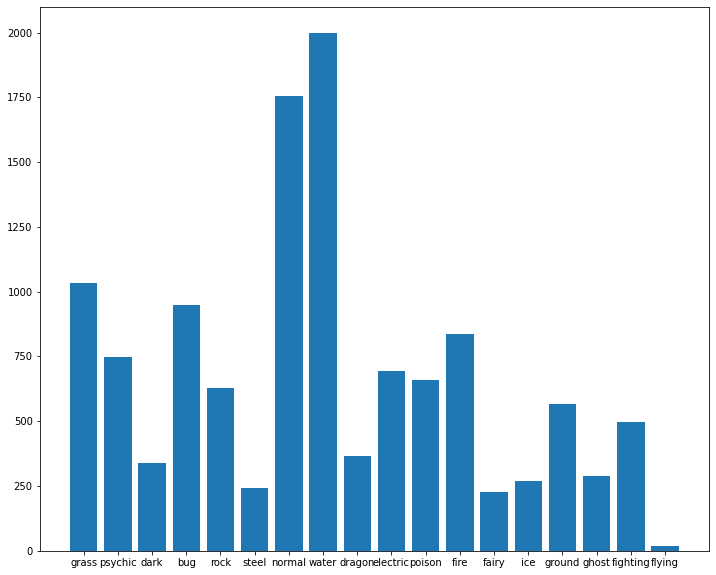

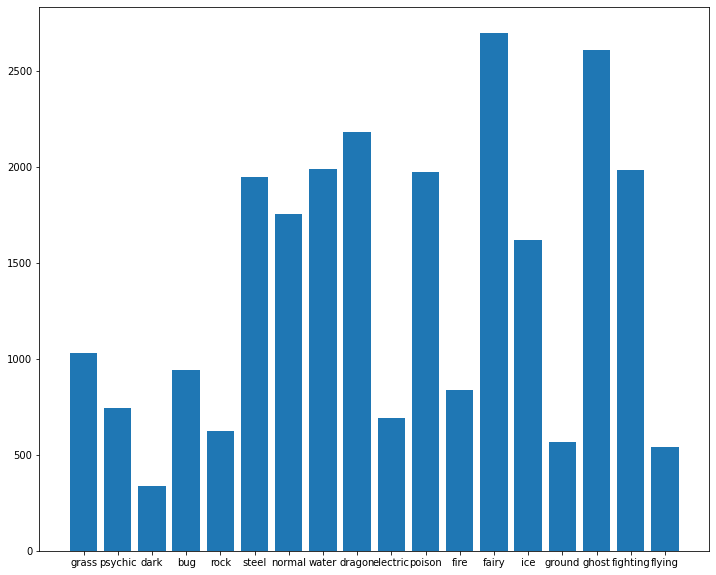

In [151]:
# Before
plt.figure(figsize=(12,10))

base_dict = count_labels(DATA_PATH, pkm_dict=pkm_dict)

pipeline_one_dict = count_labels("../../../pipeline_two/", pkm_dict=pkm_dict)
plt.bar(x=base_dict.keys(), height=base_dict.values())
plt.show()
# After
plt.figure(figsize=(12,10))
plt.bar(x=pipeline_one_dict.keys(), height=pipeline_one_dict.values())
plt.show()

## Testbereich

#### Vorbereitung

In [ ]:
labels = get_all_labels(data_path=DATA_PATH)
metadata = pd.read_csv("../metadata/pokemon.csv")

#### Tests - Strategie

In [65]:
# Create pokemon to primary type
pkm_df = metadata[["name","type1"]].loc[metadata["name"].isin(labels)]
improve_types_df = pkm_df["type1"].value_counts().loc[pkm_df["type1"].value_counts() <= pkm_df["type1"].value_counts()[0]]
pkm_df = pkm_df.set_index(list(pkm_df)[0])
pkm_dict = pkm_df.to_dict()['type1']

### Tests - Augmentation

#### Farbwerte ändern

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


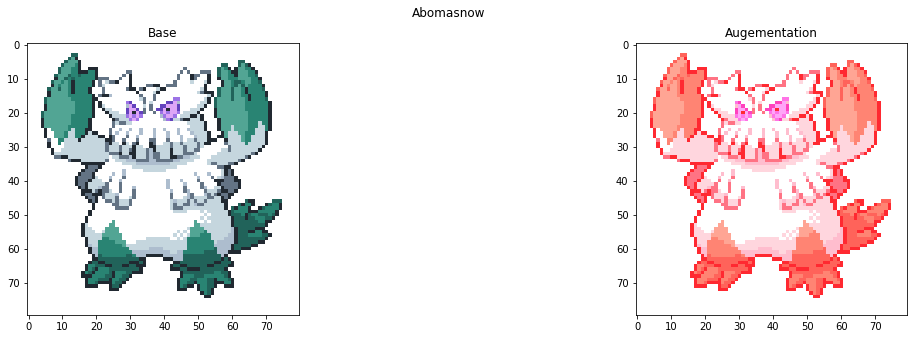

In [77]:
elements = os.listdir(f"{DATA_PATH}/{labels[0]}")
img = mpimg.imread(f"{DATA_PATH}/{labels[0]}/{elements[1]}")
figure, axes = plt.subplots(1, 2, sharex='all', figsize=(20,5))
figure.suptitle(labels[0])

axes[0].set_title('Base')
axes[0].imshow(img)
img = increase_red_color(img, 50)

axes[1].set_title('Augementation')
axes[1].imshow(img)

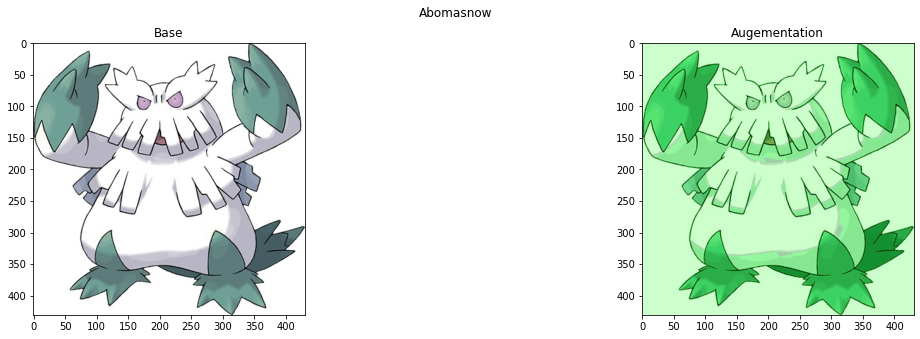

In [79]:
elements = os.listdir(f"{DATA_PATH}/{labels[0]}")
img = mpimg.imread(f"{DATA_PATH}/{labels[0]}/{elements[0]}")
figure, axes = plt.subplots(1, 2, sharex='all', figsize=(20,5))
figure.suptitle(labels[0])

axes[0].set_title('Base')
axes[0].imshow(img)
img = increase_green_color(img, 50)

axes[1].set_title('Augementation')
axes[1].imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


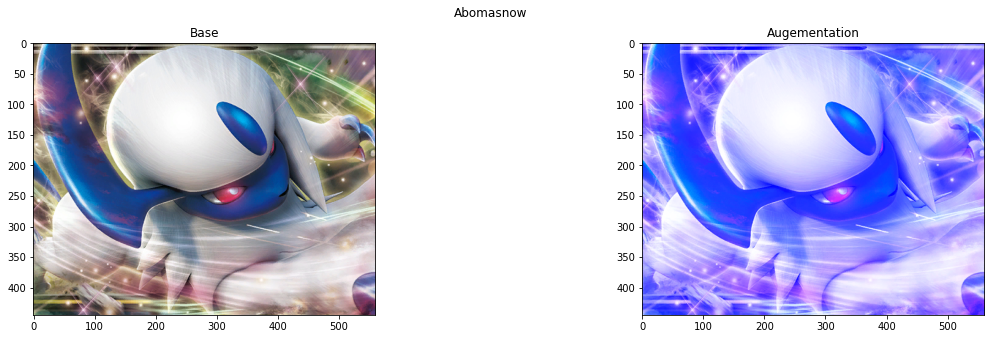

In [90]:
elements = os.listdir(f"{DATA_PATH}/{labels[2]}")
img = mpimg.imread(f"{DATA_PATH}{labels[2]}/{elements[2]}")
figure, axes = plt.subplots(1, 2, sharex='all', figsize=(20,5))
figure.suptitle(labels[0])

axes[0].set_title('Base')
axes[0].imshow(img)
img = increase_blue_color(img, 10)

axes[1].set_title('Augementation')
axes[1].imshow(img)

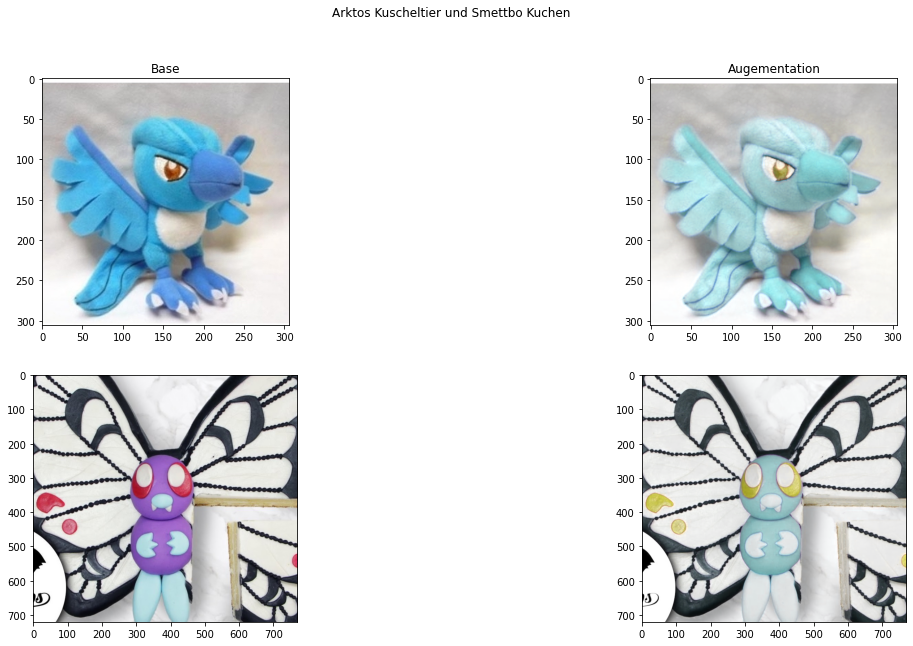

In [116]:
elements = os.listdir(f"{DATA_PATH}/{labels[24]}")
elements_two = os.listdir(f"{DATA_PATH}/{labels[70]}")
img = mpimg.imread(f"{DATA_PATH}{labels[24]}/{elements[7]}")
img_two = mpimg.imread(f"{DATA_PATH}{labels[70]}/{elements_two[3]}")
figure, axes = plt.subplots(2, 2, figsize=(20,10))
figure.suptitle("Arktos Kuscheltier und Smettbo Kuchen")

axes[0,0].set_title('Base')
axes[0,0].imshow(img)
axes[1,0].imshow(img_two)

img = img_dilation(img)
img_two = img_dilation(img_two)

axes[0,1].set_title('Augementation')
axes[0,1].imshow(img)
axes[1,1].imshow(img_two)

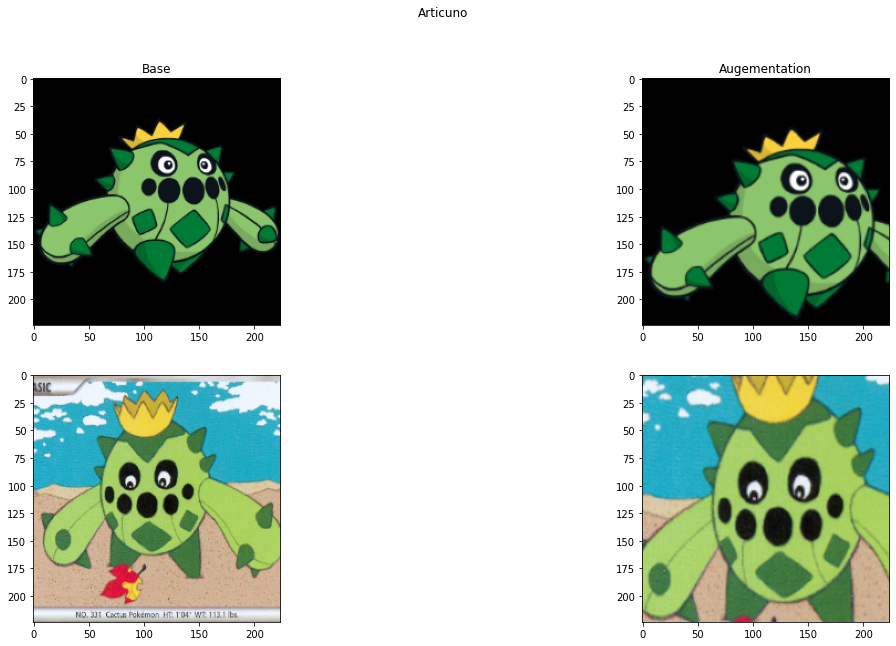

In [128]:
elements = os.listdir(f"{DATA_PATH}/{labels[71]}")
img = mpimg.imread(f"{DATA_PATH}{labels[71]}/{elements[1]}")
img_two = mpimg.imread(f"{DATA_PATH}{labels[71]}/{elements[5]}")
figure, axes = plt.subplots(2, 2, figsize=(20,10))
figure.suptitle(labels[24])

img = cv2.resize(img, (224,224))
img_two = cv2.resize(img_two, (224,224))

axes[0,0].set_title('Base')
axes[0,0].imshow(img)
axes[1,0].imshow(img_two)

img = img_random_crop(img)
img_two = img_random_crop(img_two)

axes[0,1].set_title('Augementation')
axes[0,1].imshow(img)
axes[1,1].imshow(img_two)

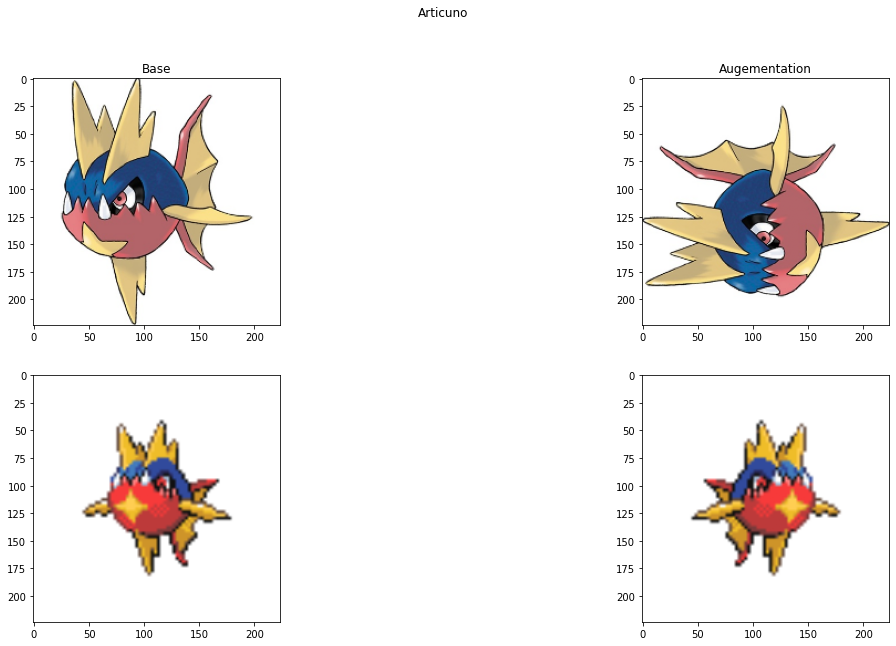

In [137]:
# Test some data augmentation techniques
elements = os.listdir(f"{DATA_PATH}/{labels[77]}")
img = mpimg.imread(f"{DATA_PATH}{labels[77]}/{elements[1]}")
img_two = mpimg.imread(f"{DATA_PATH}{labels[77]}/{elements[5]}")
figure, axes = plt.subplots(2, 2, figsize=(20,10))
figure.suptitle(labels[24])

img = cv2.resize(img, (224,224))
img_two = cv2.resize(img_two, (224,224))

axes[0,0].set_title('Base')
axes[0,0].imshow(img)
axes[1,0].imshow(img_two)

img = transform.rotate(img,90.0)
img_two = img_flip(img_two)

axes[0,1].set_title('Augementation')
axes[0,1].imshow(img)
axes[1,1].imshow(img_two)
